In [1]:
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

In [3]:
%run ts_lib

In [55]:
data_tcs = pd.read_csv('data/TCS_20200303.csv', index_col=0, parse_dates=True)
data_tcs = data_tcs.loc[~data_tcs.index.duplicated(), :] #.asfreq('B')

train_tcs = data_tcs.loc[data_tcs.index < '2016', 'Close'].diff().dropna()
val_tcs = data_tcs.loc[(data_tcs.index >= '2016') & (data_tcs.index < '2018'), 'Close'].diff().dropna()
test_tcs = data_tcs.loc[data_tcs.index >= '2018', 'Close'].diff().dropna()
train_val_tcs = data_tcs.loc[(data_tcs.index < '2018'), 'Close'].diff().dropna()

train_tcs_close = data_tcs.loc[data_tcs.index < '2016', 'Close']
val_tcs_close = data_tcs.loc[(data_tcs.index >= '2016') & (data_tcs.index < '2018'), 'Close']
test_tcs_close = data_tcs.loc[data_tcs.index >= '2018', 'Close']
train_val_tcs_close = data_tcs.loc[(data_tcs.index < '2018'), 'Close']

In [5]:
pred_window = 30
train_X = get_rolling_windows(train_tcs, pred_window + 1)
train_X, train_Y = train_X[:, :-1], train_X[:, -1].reshape((-1, 1))
val_X = get_rolling_windows(val_tcs, pred_window + 1)
val_X, val_Y = val_X[:, :-1], val_X[:, -1].reshape((-1, 1))

In [19]:
class ESM(object):
    
    def __init__(self, trend, damped, seasonal=None, periods=None, use_boxcox=False, remove_bias=False):
            self.trend = trend
            self.damped = damped
            self.seasonal = seasonal
            self.periods = periods
            self.use_boxcox = use_boxcox
            self.remove_bias = remove_bias
            
    def predict(self, history, steps=1):
        try:
            model = ExponentialSmoothing(history, trend=self.trend, damped=self.damped, seasonal=self.seasonal, 
                                             seasonal_periods=self.periods)
            model_fit = model.fit(optimized=True, use_boxcox=self.use_boxcox, remove_bias=self.remove_bias)
            yhat = model_fit.forecast(steps)
        except:
            yhat = np.full((steps,), np.NaN)
        return yhat
    
    def bulk_predict(self, X, steps):
        yhat_list = []
        for x in X:
            yhat = self.predict(x, steps)
            yhat_list.append(yhat)
        return np.array(yhat_list)
    
    def stepforward_predict(self, x, initial_history, fixed_history=False):
        pred_y = []
        if fixed_history:
            for i in range(x.shape[0] - initial_history):
                yhat = self.predict(x[i:i+initial_history])
                pred_y.append(yhat[0])
        else:
            for i in range(initial_history, x.shape[0]):
                yhat = self.predict(x[:i], steps=1)
                pred_y.append(yhat[0])
        return np.array(pred_y)


In [7]:
params = {'trend': 'add', # add, mul
          'damped': False,
          'seasonal': None, # add, mul
          'periods': None,
          'use_boxcox': False,
          'remove_bias': False}

In [75]:
def validate_esm_params(params, ts, initial_history, fixed_history=False):
    esm = ESM(**params)
    pred_y = esm.stepforward_predict(ts, initial_history, fixed_history)
    n_failures = (np.isnan(pred_y)).sum()
    mse = np.nanmean(np.square(pred_Y - ts[initial_history:]))
    return (mse, n_failures)

In [39]:
def esm_grid_search(ts, initial_history, fixed_history, params_list, parallel=False):
    results = [validate_esm_params(params, ts, initial_history, fixed_history)]
    mse_list, failure_list = zip(*results)
    mse_list = np.concatenate(mse_list, axis=0)
    failure_list = np.concatenate(failure_list, axis=0)
    mse_df = pd.DataFrame(mse_list).rename(columns={x: 'mse_{}'.format(x) for x in range(mse_list.shape[0])})
    failure_df = pd.DataFrame(failure_list).rename(columns={x: 'failures_{}'.format(x) for x in 
                                                            range(failure_list.shape[0])})
    params_df = pd.DataFrame(params_list)
    return pd.concat([params_df, mse_df, failure_df], axis=1)

In [20]:
esm = ESM(**params)

In [49]:
pred_Y = esm.stepforward_predict(train_val_tcs.values, train_tcs.shape[0] + 31)

In [51]:
np.mean(np.square(pred_Y - val_tcs[30:].values))

1098.6074655952507

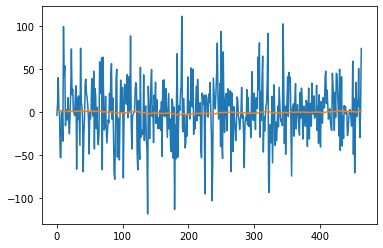

In [66]:
pd.Series(val_tcs.values[30:]).plot()
pd.Series(pred_Y).plot()

In [33]:
pred_Y = esm.bulk_predict(val_X, 1)

In [35]:
np.mean(np.square(pred_Y - val_Y))

1664.0621520649347

In [53]:
res = validate_esm_params(params, train_val_tcs.values, train_tcs.shape[0] + 31)

In [54]:
res

(1098.6074655952507, 0)

In [76]:
res = validate_esm_params(params, train_val_tcs_close.values, train_tcs_close.shape[0] + 31)

In [77]:
res

(1093.8887891165405, 0)

In [67]:
pred_Y = esm.stepforward_predict(train_val_tcs_close.values, train_tcs_close.shape[0] + 31)

In [74]:
np.mean(np.square(pred_Y - val_tcs_close.values[31:]))

1093.8887891165405

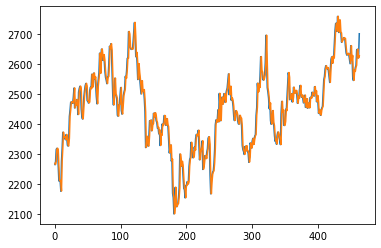

In [72]:
pd.Series(val_tcs_close.values[31:]).plot()
pd.Series(pred_Y).plot()

In [12]:
param_items = {'trend': ['add', 'mul'],
               'damped': [False, True],
               'seasonal': [None],
               'periods': [None],
               'use_boxcox': [False, True],
               'remove_bias': [False, True]}
param_list = generate_param_list(param_items)
len(param_list)

16